<img src="img/saclay_center.png" width="800" height="600">

### Datacamp Challenge : Prediction of daily transport validation in Paris public underground transports

<i> Authors :Dina ABED , Siwar ABBES, Philippe DE SAINT CHAMAS, Mohamed Skander HELLAL, Gwendal HENGOAT, Jules ZACCARDI </i>

<img src="img/sncf.jpg" width="600" height="600">

### Table of contents
1. [Business Case](#Businesscase)
2. [Libraries to install](#Libraries)
3. [Data for the challenge](#Data)
4. [Exploratory Data analysis](#Data-exploration)
5. [Prediction](#Prediction)
6. [Evaluation](#Evaluation)
7. [Local Testing](#LocalTesting)

<a id='Businesscase'></a>
## 1. Business Case

### 1.1.Introduction

The city of tomorrow will experience very strong growth in its population and in fact a sharp increase in the use of its public transport. But in the face of these new challenges, the current transport networks will have to be daring and imaginative in order to be up to these evolutions. Indeed, having to work with increasingly restrictive budgetary constraints, the transport agencies must combine flexibility and innovation. Thus, developing an offer that responds finely to demand would, among other things, provide the possibility of increasing passenger comfort while increasing the total capacity of the network, at the same operational cost.

Transport agencies consider Big Data to be the remedy for this problem and seek to efficiently use the data at their disposal in order to develop alternative solutions.

Between 2015 and 2025, demand for transport in Paris is expected to increase by 20% while the city is only ready for 9% growth in its network.

Since 2017, the Autonomous Parisian Transportation Administration (aka RATP in french) has chosen to associate itself with a comprehensive Open Data approach, which the French government has initiated with its Etalab mission, along with certain other local governments and administrations, by making some of its data accessible and usable by all. 
In this perspective, many databases are accessible online by anyone here : https://dataratp.opendatasoft.com/explore/?sort=modified. 

The goal of this challenge is to work with open data. There is a lot to do in exploiting public data and building machine learning models to improve public services. In large metropolis, there are many sources of public data which can easily made available through data collection protocols and powerful APIs. 

In Paris urban area, today almost 3 billion validation in the metro systems are counted each year and this number is continuously increasing. Handling public transports in an optimal way is one of the most important challenges for a city as global and evolving as Paris. As the city is growing and modernising, more and more suburban areas need to be connected with transports. It is our responsibility to work on improving it.  

### 1.2.Business problem

Public transports face a great deal of issues.One of them is the management of the stations.RATP is engaged in a vast program to modernize the transport network. It seeks to modernize each component of each line of the network: metro spaces, their layout, trains, control, command and driver assistance systems, passenger reception and services, equipment maintenance. and infrastructure.

Improve the climatic comfort of travelers, repair escalators in less than four hours, accelerate the spread of teleticketing, share the requirement for cleanliness, here are some of the promises that RATP is committed to respecting.

RATP is seeking to strengthen the presence of agents on the Ile-de-France network in order to offer a personalized and proactive service, geared towards customers.

In order to put these promises into practise, knowing how many people come into a given metro station each day is in RATP core business.This problem has general utility as mentioned before, but it is also powerful to solve intermittent issues,for example,during a strike as instance, RATP has to decide how to deploy its reduced workforce in an optimal way,in order to ensure a high quality service.

### 1.3.Challenge aim

This challenge is a regression task which aims at predicting the number of validation in a metro station per day. 

This is a limited scope problem.
Indeed, our data only includes the "Pass Navigo" validations, which is the season ticket of the transport net. 
First, it is a limited information on the behaviour of the users as we do not know where they have connections, neither where they exit. 
Furthermore, we don't have any information about the single use tickets validations. Intuitively, it is far from negligible as two population categories in Paris among others are concerned: tourists and working persons from other cities or other countries. They represent a massive amount of persons and there is no reason why they should have the same behaviour as the persons taken into acount in our data.

We consider that our problem gives an idea anyway of the frequentation of the stations.

### 1.4.Business Metric

We shall use the following score:

$$score =  |max(3,log_{10}(max(5,y\_true))) - max(3,log_{10}(max(5,y\_pred)))| $$

The goal is to minimize it. We can say that:
* If y_true or y_pred is smaller than 5 is, we give it the value 5 to correspond to the minimum value we have taken during the agregation to replace "moins de 5" values
* If the prediction and the real values are inferior to 1000, we take a score equal to 0, as we consider that small stations get the same treatment whatever 
* This metric penalizes more a same gap between y_true and y_pred for small values than for large values.

This kind of error is more adequate to our data than classical losses as MSE or MAE which explode as soon as we mistake a big and a small station.

This was inspired by the "Starting kit for the FAN revenue prediction RAMP challenge" (https://github.com/ramp-kits/fan_revenue_prediction)
from the "RAMP starting kits" (https://github.com/ramp-kits) github repository.

<a id='Libraries'></a>
## 2.Libraries to install

This starting kit requires the following libraries:

* `numpy`
* `pandas`
* `seaborn`
* `scikit-learn`
* `matplolib`
* `folium`
* `calendar`
* `datetime`
* `IPythhon`

We recommand you to install these libraries using `conda` (using the [`Anaconda`](https://www.anaconda.com/distribution/) distribution).

For this challenge, `ramp-workflow` is also needed. This can be installed from the master branch on GitHub:

      python -m pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master

<a id='Data'></a>
## 3 . Data for the challenge

### Import Libraries

In [1]:
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import folium
import pandas as pd
import calendar

from datetime import timedelta, date
from IPython.display import display
from folium import Popup

%matplotlib inline
sns.set_style('ticks')
sns.set(rc={'figure.figsize':(13.7,9.27)})
warnings.filterwarnings('ignore')

### Loading the Data

<p>In order to download the datasets,It is <b><span style="color:red">important that you run first </span></b> `download_data.py`.You will get a zip file called `data.zip`.</p>
<p> <b><span style="color:red">You need to create a new folder </span></b>  `data` and extract  `data.zip` in the folder created. </p>

In [2]:
from problem import get_train_data

X_train,y_train = get_train_data()
X_train.shape , y_train.shape

((766110, 21), (766110,))

### 3.1 Basic data exploited
The Basic data used are in our challenge are the open data available on the Ile-de-France Mobilités platform which provides validation data of the entire Ile-de-France network. The transport network seen by the validation data covers 725 train stops (RER, metro, Transilien). 
Source: https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations/information/

We have merged all the data available since the first semester of 2015 until 2019. To get a whole observations of the number of validations per day and per stop. 

### 3.2 Adding more features to ou basic data
Thinking about some informations that could impact the frequentation of stations, our brainstorming leads to try to find other databases that contain these significant features to our business model:

- find to which metro/RER line corresponds each stop, Database exploited: https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf-data-generalisee/information/
- Search for a database of public holidays (whether public holiday or not and if so, the type of this day: Weekend, Christmas, Toussaint,...), Database exploited: https://www.data.gouv.fr/fr/datasets/jours-feries-en-france/
- Incident rate, incident data on all RATP lines per day, Database exploited: http://data.cquest.org/openeventdatabase/
- Social movements, Data on SNCF social movements: https://ressources.data.sncf.com/explore/dataset/mouvements-sociaux-depuis-2002/table/?sort=date_de_debut
- Referential of passenger stations, Database: https://data.sncf.com/explore/dataset/frequentation-gares/table/?sort=nom_gare

- Day off Database indicating if the day is a day off or not and the type of the day off:
https://www.data.gouv.fr/fr/datasets/jours-feries-en-france/

The dataset provided was built using the RATP open data, by merging many these different datasets. Each row gives the following information for one station at one day : 
   
* `NB_VALD` : total number of validation at this station for the day.This is the target for our problem 
* `JOUR`
* `LIBELLE_ARRET` : name of the station
* `lon` : longitude of the station
* `lat` : latitude
* `res_com` : list of lines at this station
* `mode_` : list of types of lines at this station
* `principal` : boolean indicating the station is principal or not
* `nb_rer` : number of RER at this station
* `nb_metro` : number of metros at this station
* `Nbre plateformes` : number 
* `duree` : total duration of incidents this day on the lines going through the station
* `type_inc` : type of incidents this day on the lines going through the station 
* `num_inc` : total number of incidents this day on the lines going through the station 
* `est_grev` : boolean indicating if this day is a strike or not 
* `Jour de la semaine` : day of the week 
* `Horaire en jour normal`: stations opening and closing times in business days
* `Horaire en jour ferié` : stations opening and closing times in day off
* `est_jour_ferie`: boolean indicating it is a day off or not
* `type_jour`: day type : types of days off 

In [3]:
X_train.head()

,JOUR,LIBELLE_ARRET,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line,...,Nbre plateformes,duree,type_inc,num_inc,est_greve,Jour de la semaine,Horaire en jour normal,Horaire en jour férié,est_jour_ferie,type_jour
0,2015-12-01,LES GRESILLONS,NaN,NaN,RER C,RER,0.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,0.0,Tuesday,NaN,NaN,0,Jour non ferie
1,2015-11-25,ERMONT-HALTE,NaN,NaN,LIGNE H,Train,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,0.0,Wednesday,NaN,NaN,0,Jour non ferie
2,2016-09-19,COURCELLE-SUR-YVETTE,48.700934,2.099045,RER B,RER,0.0,0.0,1.0,B,...,NaN,NaN,NaN,NaN,0.0,Monday,NaN,NaN,0,Jour non ferie
3,2019-02-23,RAMBOUILLET,48.844479,2.381176,LIGNE N,Train,1.0,0.0,0.0,NaN,...,1.0,NaN,NaN,NaN,0.0,Saturday,NaN,NaN,0,Weekend
4,2019-02-27,FR. POPULAIRE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,Wednesday,NaN,NaN,0,Jour non ferie


In [4]:
X_train.describe()

,lon,lat,principal,nb_metro,nb_rer,Nbre plateformes,num_inc,est_greve,est_jour_ferie
count,439493.000000,439493.000000,744435.000000,747321.000000,747321.000000,185019.0,94677.000000,766110.000000,766110.000000
mean,48.859397,2.343536,0.104487,0.729471,0.350369,1.0,7.304836,0.197455,0.030624
std,0.045919,0.088234,0.305892,0.966243,0.516997,0.0,20.094824,0.398079,0.172296
min,48.695061,2.012258,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000
25%,48.843076,2.305558,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000
50%,48.861193,2.346203,0.000000,0.000000,0.000000,1.0,2.000000,0.000000,0.000000
75%,48.880790,2.385203,0.000000,1.000000,1.000000,1.0,5.000000,0.000000,0.000000
max,49.049765,2.773608,1.000000,5.000000,3.000000,1.0,356.000000,1.000000,1.000000


In [5]:
X_train['NB_VALD'] = y_train
X_train.groupby('LIBELLE_ARRET')['NB_VALD'].mean().to_clipboard()

In [6]:
X_train.isna().sum() / X_train.shape[0]

JOUR                      0.000000
LIBELLE_ARRET             0.000000
lon                       0.426332
lat                       0.426332
res_com                   0.028292
mode_                     0.028292
principal                 0.028292
nb_metro                  0.024525
nb_rer                    0.024525
line                      0.569426
Segment DRG               0.759647
Nbre plateformes          0.758496
duree                     0.876419
type_inc                  0.876419
num_inc                   0.876419
est_greve                 0.000000
Jour de la semaine        0.000000
Horaire en jour normal    0.975530
Horaire en jour férié     0.977255
est_jour_ferie            0.000000
type_jour                 0.000000
NB_VALD                   0.000000
dtype: float64

In [7]:
X_train.nunique()

JOUR                       1458
LIBELLE_ARRET               735
lon                         385
lat                         385
res_com                     140
mode_                        15
principal                     2
nb_metro                      6
nb_rer                        4
line                         18
Segment DRG                   3
Nbre plateformes              1
duree                       591
type_inc                     11
num_inc                     122
est_greve                     2
Jour de la semaine            7
Horaire en jour normal       27
Horaire en jour férié        14
est_jour_ferie                2
type_jour                    13
NB_VALD                   40607
dtype: int64

In [8]:
X_train.dtypes

JOUR                       object
LIBELLE_ARRET              object
lon                       float64
lat                       float64
res_com                    object
mode_                      object
principal                 float64
nb_metro                  float64
nb_rer                    float64
line                       object
Segment DRG                object
Nbre plateformes          float64
duree                      object
type_inc                   object
num_inc                   float64
est_greve                 float64
Jour de la semaine         object
Horaire en jour normal     object
Horaire en jour férié      object
est_jour_ferie              int64
type_jour                  object
NB_VALD                     int64
dtype: object

<a id='Data-exploration'></a>
##  4 . Exploratory Data analysis

### 4.1.Day_Off

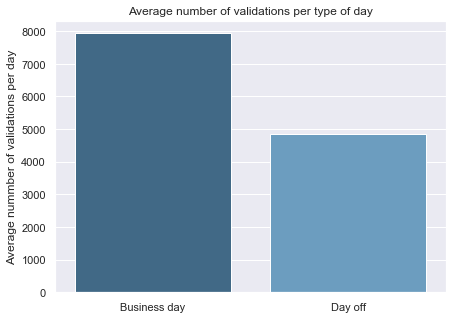

In [9]:
data_train_jour_ferie = X_train.groupby('est_jour_ferie').agg({'NB_VALD':'mean'})
plt.figure(figsize=(7,5))
index = np.arange(data_train_jour_ferie.shape[0])
ax = sns.barplot(x=index, y=data_train_jour_ferie['NB_VALD'], data=data_train_jour_ferie, palette="Blues_d")
ax = ax.set_xticklabels(["Business day","Day off"])
plt.ylabel('Average nummber of validations per day')
plt.title('Average number of validations per type of day')
plt.show()

As expected, the number of transport validations is more important in business days.

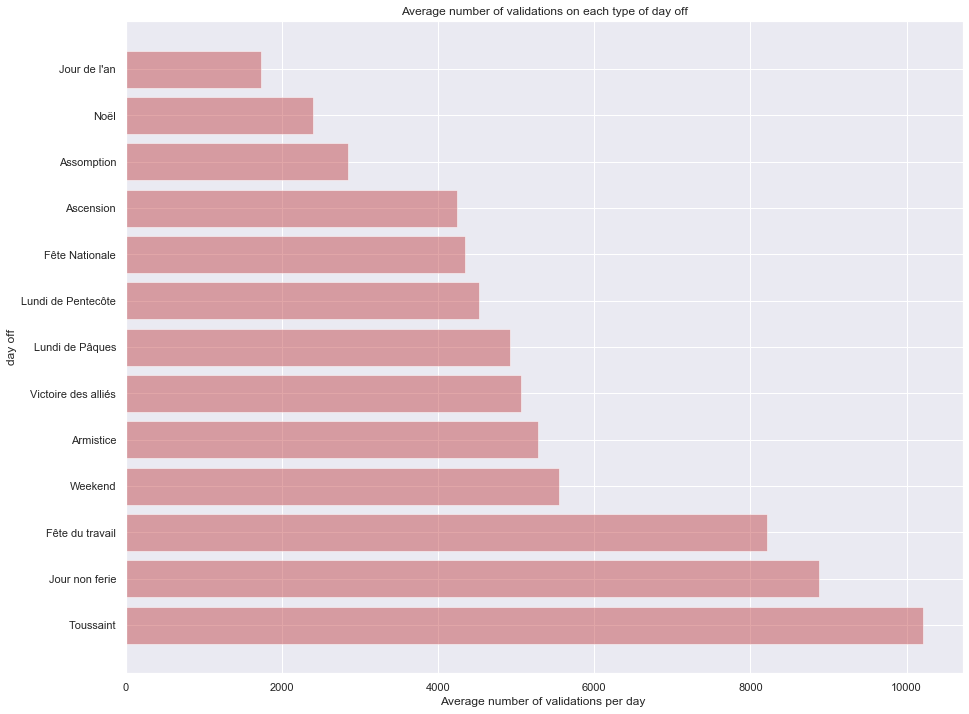

In [10]:
#Let's see the average number of validations on each type of day off
data_train_type_jour = X_train.groupby('type_jour').agg({'NB_VALD':'mean'})
data_train_type_jour = data_train_type_jour.sort_values(by='NB_VALD', ascending=False)

plt.figure(figsize=(15,12))
index = np.arange(data_train_type_jour.shape[0])
plt.barh(index, data_train_type_jour['NB_VALD'], alpha=0.5, color='r')
plt.yticks(range(data_train_type_jour.shape[0]), data_train_type_jour.index)
plt.ylabel('day off')
plt.xlabel('Average number of validations per day ')
plt.title('Average number of validations on each type of day off')
plt.show()

As we can see, the number of transport validations varies according to the type of holiday.

### 4.2. Number of validations per month

In [11]:
X_train.loc[X_train['NB_VALD'] == X_train['NB_VALD'].max()]

,JOUR,LIBELLE_ARRET,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line,...,duree,type_inc,num_inc,est_greve,Jour de la semaine,Horaire en jour normal,Horaire en jour férié,est_jour_ferie,type_jour,NB_VALD
411475,2017-12-14,LA DEFENSE-GRANDE ARCHE,48.891916,2.237488,LIGNE L / LIGNE U / RER A / M1 / T2,Train / RER / Metro / Tramway,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,0,Jour non ferie,219051


In [12]:
# Feature Engineering : Month
X_train['JOUR'] = pd.to_datetime(X_train['JOUR'])
X_train['mois'] = X_train['JOUR'].apply( lambda val: val.month)
X_train.head()

,JOUR,LIBELLE_ARRET,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line,...,type_inc,num_inc,est_greve,Jour de la semaine,Horaire en jour normal,Horaire en jour férié,est_jour_ferie,type_jour,NB_VALD,mois
0,2015-12-01,LES GRESILLONS,NaN,NaN,RER C,RER,0.0,0.0,1.0,NaN,...,NaN,NaN,0.0,Tuesday,NaN,NaN,0,Jour non ferie,3008,12
1,2015-11-25,ERMONT-HALTE,NaN,NaN,LIGNE H,Train,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,Wednesday,NaN,NaN,0,Jour non ferie,544,11
2,2016-09-19,COURCELLE-SUR-YVETTE,48.700934,2.099045,RER B,RER,0.0,0.0,1.0,B,...,NaN,NaN,0.0,Monday,NaN,NaN,0,Jour non ferie,1091,9
3,2019-02-23,RAMBOUILLET,48.844479,2.381176,LIGNE N,Train,1.0,0.0,0.0,NaN,...,NaN,NaN,0.0,Saturday,NaN,NaN,0,Weekend,2718,2
4,2019-02-27,FR. POPULAIRE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,Wednesday,NaN,NaN,0,Jour non ferie,7627,2


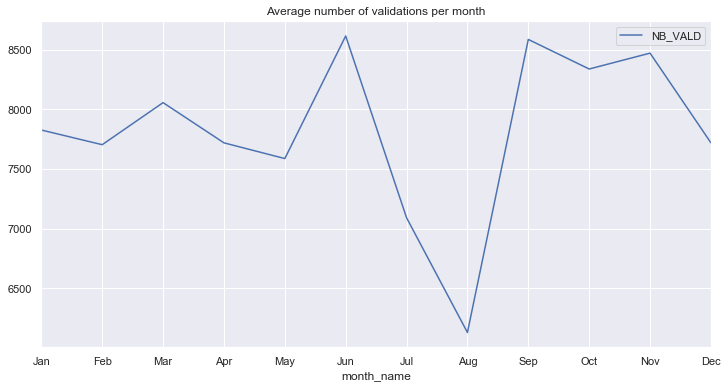

In [13]:
data_vis = X_train.copy()
data_vis['month_name'] = X_train['JOUR'].apply( lambda val: val.month)
data_vis = data_vis.groupby('month_name').agg({'NB_VALD': 'mean'}).plot(figsize=(12,6))
ticks = list(range(1, 13, 1)) # points on the x axis where labels appear
labels = 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
plt.xticks(ticks,labels)
plt.title('Average number of validations per month');

We can notice that the number of transport validations is more important in the last 4 months of the year. However, it is minimal in August when most of people take a summer break.


### 4.3. Number of validations per week_day

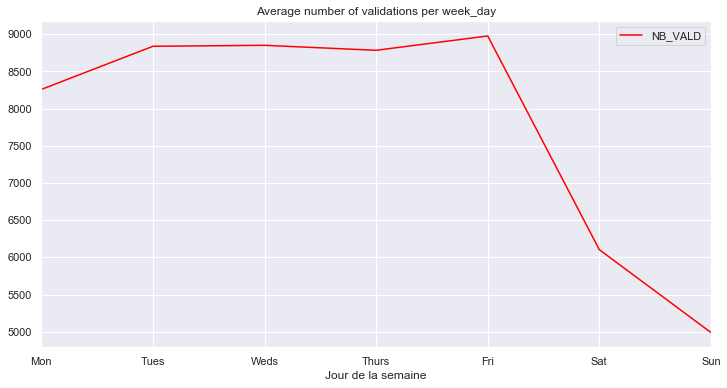

In [14]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
X_train.groupby('Jour de la semaine').agg({'NB_VALD': 'mean'}).reindex(days).plot(figsize=(12,6), color='red')
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks,labels)
plt.title('Average number of validations per week_day');

As expected, the number of transport validations is high in principly in business days. It is less important on Mondays because most of days off in our data are on Mondays.

### 4.4 .Heatmap : Number of validations per station

In [15]:
data_map = X_train.groupby(['LIBELLE_ARRET']).agg({'NB_VALD': 'mean','lon':'mean','lat':'mean'}).reset_index()
data_map['nb_valid_per_month'] = (data_map['NB_VALD']).astype(int)
data_map = data_map[pd.notnull(data_map['lon'])]
data_map.reset_index(level=0, inplace=True)
data_map.head()

,index,LIBELLE_ARRET,NB_VALD,lon,lat,nb_valid_per_month
0,0,ABBESSES,3050.731282,48.884505,2.338365,3050
1,2,ACHERES-GRAND-CORMIER,57.421376,48.955388,2.092457,57
2,3,ACHERES-VILLE,3423.778826,48.970248,2.077672,3423
3,4,AEROPORT CHARLES DE GAULLE 1,4474.917635,49.010400,2.561357,4474
4,5,AEROPORT CHARLES DE GAULLE 2-TGV,4768.921360,49.004199,2.570946,4768


In [16]:
LDN_COORDINATES = (48.8534, 2.3488)
myMap = folium.Map(location=LDN_COORDINATES, zoom_start=11)
for i in range(0,len(data_map)):
    folium.Circle(
      location=[data_map.iloc[i]['lon'], data_map.iloc[i]['lat']],
      popup= Popup('<h3>'+ str(data_map.iloc[i]['LIBELLE_ARRET']).upper() + '</h3>' + '<br>'
                 '<b> Mean_Nb_valid_per_Day: </b>' + str(data_map.iloc[i]['nb_valid_per_month']) + '<br>'
                      
                ),
      radius= data_map.iloc[i]['nb_valid_per_month'].astype(float)/100 ,
      color='crimson',
      fill=True,
      fill_color='crimson',
        

   ).add_to(myMap)
 
display(myMap)
myMap.save(outfile= "Map.html")

We can observe on the map that our data cover Paris and many other close cities. We remark that the number of validation is higher in center of Paris and in the station "La Défense-Grande Arche". 
As we can see below, if we click at a station, we can observe the average number of validation per month corresponding to this station.

[![map.png](https://i.postimg.cc/1Xq1th2N/map.png)](https://postimg.cc/5QbR7Gxx)

#### Top 5 stations with higher number of validations per month

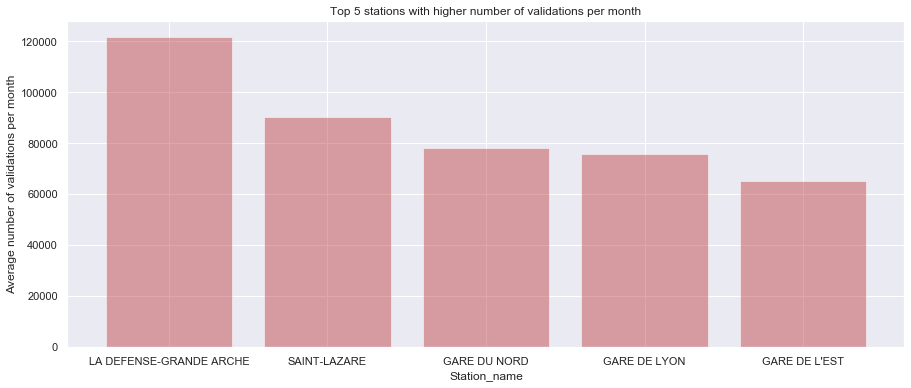

In [17]:
data_map = data_map.sort_values(by='nb_valid_per_month', ascending=False)[:5]

plt.figure(figsize=(15,6))
y_pos = np.arange(data_map.shape[0])
rects = plt.bar(y_pos, data_map['nb_valid_per_month'], align='center', alpha=0.5, color='r')
plt.xticks(y_pos, data_map['LIBELLE_ARRET'])
plt.ylabel('Average number of validations per month')
plt.xlabel('Station_name')
plt.title('Top 5 stations with higher number of validations per month')
plt.show()

As we can see here, the plot confirms the output of the heat map showed previously. 

### 4.5.  Validation and Stations characteristics

#### 4.5.1 . Validation average with RER number per station 

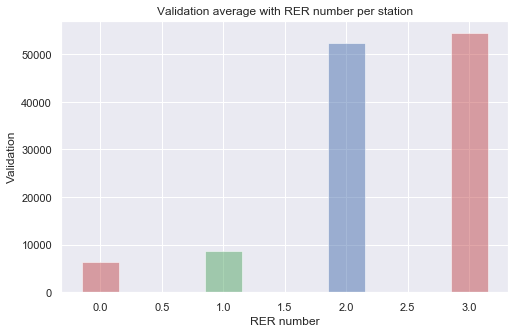

In [18]:
data_gare_vld = X_train[['NB_VALD','principal','nb_rer','nb_metro','Nbre plateformes']]

data_nb_rer = data_gare_vld.groupby('nb_rer').agg({'NB_VALD':'mean'}).reset_index()
plt.figure(figsize=(8,5))
plt.subplots_adjust(hspace=2)
index = np.arange(data_nb_rer.shape[0]).tolist()
plt.bar(index, data_nb_rer['NB_VALD'], width=0.3,alpha=0.5,color = ['r','g','b'])

plt.ylabel('Validation')
plt.xlabel('RER number')
plt.title('Validation average with RER number per station')
plt.show()

We can notice that more the station corresponds to RERs, higher is the number of transport validations

#### 4.5.2.  Validation average with Metro number per station 

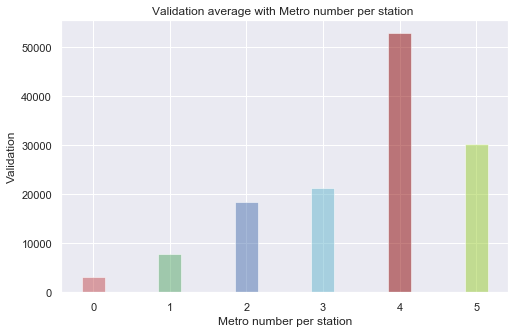

In [19]:
data_nb_metro = data_gare_vld.groupby('nb_metro').agg({'NB_VALD':'mean'})
plt.figure(figsize=(8,5))
index = np.arange(data_nb_metro.shape[0])
plt.bar(index, data_nb_metro['NB_VALD'], width=0.3,alpha=0.5, color= ['r','g','b','c','darkred','yellowgreen'])

plt.ylabel('Validation')
plt.xlabel('Metro number per station')
plt.title('Validation average with Metro number per station ')
plt.show()

We can notice that the number of validation does not depend on the number of metros in the station.We can conclude that the number of validations depends on other factors.

#### 4.5.3 . Validation average with station type

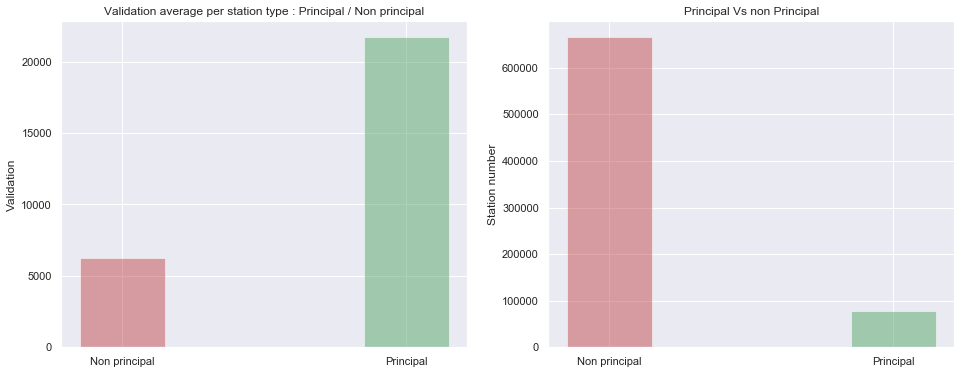

In [20]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
data_principal = data_gare_vld.groupby('principal').agg({'NB_VALD':'mean'})
index = np.arange(data_principal.shape[0])
plt.bar(index, data_principal['NB_VALD'], width=0.3,alpha=0.5, color= ['r','g'])
plt.xticks([1,0],('Principal','Non principal'))
plt.ylabel('Validation')
plt.title('Validation average per station type : Principal / Non principal')

plt.subplot(1,2,2)
data_nbr_principal = data_gare_vld.groupby('principal')['principal'].count()
index = np.arange(data_nbr_principal.shape[0])
plt.bar(index, data_nbr_principal.values, width=0.3,alpha=0.5, color= ['r','g'])
plt.xticks([1,0],('Principal','Non principal'))
plt.ylabel('Station number')
plt.title('Principal Vs non Principal')
plt.show()

We can notice that the number of validations depends on the type of the stations,whether it is principal or not principal.In fact, principal stations tend to have the highest validation numbers.

<a id='Prediction'></a>
## 5. Prediction

### 5.1.Feature Extractor

In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline



class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):

        X_encoded = X_df

        def process_date(X):
            date = pd.to_datetime(X['JOUR'], format='%Y-%m-%d')
            return np.c_[date.dt.year, date.dt.month, date.dt.day]
        
        date_transformer = FunctionTransformer(process_date, validate=False)

        numeric_transformer = Pipeline(steps=[ ('impute', SimpleImputer(strategy='median'))])

        date_cols = ['JOUR']
        num_cols = ['lon','lat','nb_metro','nb_rer','principal','Nbre plateformes','num_inc','est_greve','est_jour_ferie']
        drop_cols = ['duree', 'type_inc', 'res_com', 'mode_','line', 'Segment DRG', 'duree', 'type_inc', 'Jour de la semaine', 
                     'Horaire en jour normal', 'Horaire en jour férié', 'type_jour']


        preprocessor = ColumnTransformer(transformers=[
            ('date', make_pipeline(date_transformer,SimpleImputer(strategy='median')), date_cols),
            ('num', numeric_transformer, num_cols),
            ('drop cols', 'drop', drop_cols)
        ])
        
        self.preprocessor = preprocessor
        self.preprocessor.fit(X_encoded, y_array)
        return self

    def transform(self, X_df):
        X_encoded = X_df
        return self.preprocessor.transform(X_encoded)


### 5.2.Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
import numpy as np 

class Regressor(BaseEstimator):
    def __init__(self):
        self.MYReg = TransformedTargetRegressor(
        regressor=RandomForestRegressor(n_estimators=30,max_depth=12),
        func=lambda u: np.log10(np.clip(u, a_min=1, a_max=None)),
        inverse_func=lambda u: np.power(10, u),
        check_inverse=False,
        )

    def fit(self, X, y):
        return self.MYReg.fit(X, y)

    def predict(self, X):
        return self.MYReg.predict(X) 

<a id='Evaluation'></a>
## 6. Evaluation 

In order to test our model, we are going to define the loss function.

In [23]:
def loss(y_true, y_pred):
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    max_true = np.maximum(3., np.log10(np.maximum(5., y_true)))
    max_pred = np.maximum(3., np.log10(np.maximum(5., y_pred)))
    
    loss = np.mean(np.abs(max_true - max_pred))
    
    return loss

Now, we are going to perform the test on our model

In [24]:
from sklearn.model_selection import train_test_split

# Data split
X_train  = X_train.drop(['NB_VALD'], axis=1)
X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Prediction
model = make_pipeline(FeatureExtractor(), Regressor())
model.fit(X_train_model, y_train_model)
y_pred = model.predict(X_test_model)

# loss
loss(y_test_model,y_pred)

0.18878749404934275

We are going to apply Cross-validation

In [27]:
from sklearn.metrics import make_scorer
from problem import get_cv
from sklearn.model_selection import cross_val_score

#The model
model = make_pipeline(FeatureExtractor(), Regressor())

# Cross validation
ratp_loss = make_scorer(loss, greater_is_better=False)
cv = get_cv(X_train,y_train)

score = -cross_val_score(model, X_train, y_train,
                              cv=cv, scoring=ratp_loss,
                              groups=X_train['LIBELLE_ARRET'], n_jobs=2)

print("mean: %e (+/- %e)" % (score.mean(), score.std()))

mean: 2.652382e-01 (+/- 1.656451e-02)


<a id='LocalTesting'></a>
## 7. Local Testing 

<p>In ordrer to test your submission files before submitting, we provide a unit test - `ramp_test_submission`.</p>
<p>It is <b><span style="color:red">important that you install </span></b> `ramp-worflow`.</p>
<p> Now you can use `ramp_test_submission`. This command will test on files in [`submissions/starting_kit`](/submissions/starting_kit) by default. </p>
<p> If it runs and print training and test errors on each fold, then you can submit the code.</p>
<p>For example, below we test the starting kit:</p>

In [26]:
!ramp_test_submission

Testing Prediction of daily validation in Paris public underground transports
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  ratp error       time
	train       0.189  35.602020
	valid       0.238   2.165439
	test        0.201   1.058665
CV fold 1
	score  ratp error       time
	train       0.185  36.132850
	valid       0.247   2.182406
	test        0.199   1.055338
CV fold 2
	score  ratp error       time
	train       0.180  34.619025
	valid       0.290   2.200684
	test        0.206   1.078256
CV fold 3
	score  ratp error       time
	train       0.190  36.740239
	valid       0.257   2.189215
	test        0.205   1.058414
CV fold 4
	score  ratp error       time
	train       0.183  36.130757
	valid       0.269   2.120428
	test        0.202   1.040767
CV fold 5
	score  ratp error       time
	train       0.182  33.417609
	valid       0.257   2.572742
	test        0.198   1.230099
CV fold 6
	score  ratp error       time
	tra

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).